# Rasterio Tutorial
[FOSS4G UK 2019](https://uk.osgeo.org/foss4guk2019/) - [Workshop 'Geoprocessing with Jupyter Notebooks'](https://github.com/samfranklin/foss4guk19-jupyter)  
[Sam Franklin](https://github.com/samfranklin) - [SCISYS](https://www.scisys.co.uk/)

## Introduction

Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models.  The `Rasterio` package reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.


### Objectives:
* Read multiple raster datasets
* Inspect properties of the raster, e.g. get the bounds, cordinate reference system, etc ... 
* Use matplotlib library to make plots including a 2D map, contour plot, histogram of values
* Merge multiple ASCIIgrid files to single, compressed GeoTIFF
* Read a vector linestring using the geopandas library
* Create a "profile" or transect of elevation along a route and visualise.
* export the 2D plot to a csv file

#### References:
* [Rasterio Documentation](https://rasterio.readthedocs.io/en/stable/) - Read the docs!
* [Ordnance Survey Open Data - OS Terrain 50](https://www.ordnancesurvey.co.uk/business-and-government/help-and-support/products/terrain-50.html) - for open UK Digital Elevation Model data
* https://overpass-turbo.eu - an interface for extracting data from [OpenStreetMap](https://www.openstreetmap.org/)

#### Acknowledgements:
* Contains OS data © Crown copyright and database right (2019)
* "© OpenStreetMap contributors", further copyright information is available [here](https://www.openstreetmap.org/copyright)

In [71]:
import rasterio as rs
from rasterio import merge
import os
import zipfile
from matplotlib import pyplot
from rasterio.plot import show
from rasterio.plot import show_hist
from os import listdir
from os.path import isfile, join
from osgeo import gdal
import importlib
import geopandas
import pandas
import numpy as np
from datetime import datetime
import utilities
from utilities import make_equidistant_points_from_linstring
import matplotlib.pyplot as plt

# Part 1. Read multiple DEM files data with rasterio + simple plotting

Note, the data for this part of the tutorial all sits in this repo's `./tutorial/data/dem-raw/` directory

In [72]:
# get current directory using a notebook "magic"
!pwd

/mnt/d/documents/code/foss4guk19-jupyter/tutorials


<div class="alert alert-warning">
    <strong>NOTE</strong>
    <br>This is a good time to talk about Jupyter Notebook magics which is what "!pwd"
    <br> Magics are special built-in functions.
    <br> A full list of supported magics are in <a href="https://ipython.org/ipython-doc/3/interactive/magics.html">the docs</a>
</div>

Let's start by making some local directories for data if they don't exist already

In [73]:
root = os.getcwd()
pth_raw = os.path.join(os.path.join(root,'data'),'dem-raw')
if not os.path.exists(pth_raw):
    os.makedirs(pth_raw)
print('raw data dir\t\t=' + pth_raw)
    
pth_cwd = os.path.join(os.path.join(root,'data'),'dem-working')
if not os.path.exists(pth_cwd):
    os.makedirs(pth_cwd)
print('working data dir\t=' + pth_cwd)    

raw data dir		=/mnt/d/documents/code/foss4guk19-jupyter/tutorials/data/dem-raw
working data dir	=/mnt/d/documents/code/foss4guk19-jupyter/tutorials/data/dem-working


Next, we need to make a list of all the 'raw' dem, we can do this with a for loop and list comprehension

In [74]:
onlyfiles = [f for f in listdir(pth_raw) if isfile(join(pth_raw, f))]

Check the list's first entry, you should have `nt00_OST50GRID_20170713.zip`

In [75]:
onlyfiles[0]

'nt00_OST50GRID_20170713.zip'

next, extract the all the .asc and .prj files from the .zip file and extract to different directory, this cell does this for you

In [76]:
raster_list = []
for ifile in onlyfiles:
    input_zip = os.path.join(pth_raw,ifile)
    zipobj = zipfile.ZipFile(input_zip)
    for i in zipobj.filelist:
        if i.filename.endswith('.asc'):
            zipobj.extract(i.filename,pth_cwd)
            raster_list.append(os.path.join(pth_cwd,i.filename))
            print('extracting :: ' + i.filename)
        elif i.filename.endswith('.prj'):
            zipobj.extract(i.filename,pth_cwd)
print('raster list completed')

extracting :: NT00.asc
extracting :: NT01.asc
extracting :: NT02.asc
extracting :: NT03.asc
extracting :: NT04.asc
extracting :: NT05.asc
extracting :: NT06.asc
extracting :: NT07.asc
extracting :: NT08.asc
extracting :: NT09.asc
extracting :: NT10.asc
extracting :: NT11.asc
extracting :: NT12.asc
extracting :: NT13.asc
extracting :: NT14.asc
extracting :: NT15.asc
extracting :: NT16.asc
extracting :: NT17.asc
extracting :: NT18.asc
extracting :: NT19.asc
extracting :: NT20.asc
extracting :: NT21.asc
extracting :: NT22.asc
extracting :: NT23.asc
extracting :: NT24.asc
extracting :: NT25.asc
extracting :: NT26.asc
extracting :: NT27.asc
extracting :: NT28.asc
extracting :: NT29.asc
extracting :: NT30.asc
extracting :: NT31.asc
extracting :: NT32.asc
extracting :: NT33.asc
extracting :: NT34.asc
extracting :: NT35.asc
extracting :: NT36.asc
extracting :: NT37.asc
extracting :: NT38.asc
extracting :: NT39.asc
extracting :: NT40.asc
extracting :: NT41.asc
extracting :: NT42.asc
extracting 

Check the list's first entry, you should have a path that looks roughly like `./foss4guk19-jupyter/tutorials/data/dem-working/NT00.asc`

In [77]:
raster_list[:1]

['/mnt/d/documents/code/foss4guk19-jupyter/tutorials/data/dem-working/NT00.asc']

Open the the first raster dataset in the list with rasterio with the `open` method  
Note, this doesn't read the actual pixel values of the raster data, we'll do this later  

In [78]:
src = rs.open(raster_list[0])

Now we have opened the raster as a rasterio dataset, we can start to get more information about it, try several of the following attributes:
```python
src.meta        # to retrieve metadata, similar to a 'gdalinfo'
src.bounds      # to retrieve bounding box info
src.crs         # prints the cordinate reference system info held
src.transform   # print raster transform from pixel to raster coords

```

In [79]:
src.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': None,
 'width': 200,
 'height': 200,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",400000],PARAMETER["False_Northing",-100000],PARAMETER["Central_Meridian",-2],PARAMETER["Scale_Factor",0.999601272],PARAMETER["Latitude_Of_Origin",49],UNIT["Meter",1]]'),
 'transform': Affine(50.0, 0.0, 300000.0,
        0.0, -50.0, 610000.0)}

In [80]:
src.bounds

BoundingBox(left=300000.0, bottom=600000.0, right=310000.0, top=610000.0)

In [81]:
src.crs

CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",400000],PARAMETER["False_Northing",-100000],PARAMETER["Central_Meridian",-2],PARAMETER["Scale_Factor",0.999601272],PARAMETER["Latitude_Of_Origin",49],UNIT["Meter",1]]')

In [82]:
src.transform

Affine(50.0, 0.0, 300000.0,
       0.0, -50.0, 610000.0)

_Enough_ with metadata, let's **READ** the first band of the DEM and plot. 

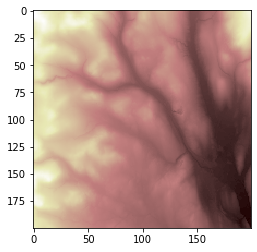

In [83]:
# plot the data (no geographic info)
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

<div class="alert alert-warning">
    <strong>NOTE</strong>
    <br>The above image is okay, but note the units of the plot. These are pixel units, and not geographic coordinates.
    <br> plot.show() is a simple image viewer method.
    <br> to plot geographically, use the inbuilt rasterio 'show' function, below 
</div>

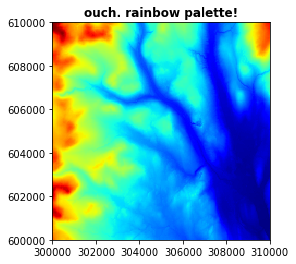

In [84]:
show(src.read(), transform=src.transform, cmap='jet', title='ouch. rainbow palette!');

<div class="alert alert-info">
    <strong>ACTIVITY</strong>
    <br>Right, let's not use the 'jet' colormap palette (see 'cmap=' above).
    <br>Go over to Matplotlib's <a href="https://matplotlib.org/tutorials/colors/colormaps.html">cmap documentation</a> (scroll down) and select a different cmap name, then rerun the cell above with your update
</div>

The `rasterio` plot method, is just a wrapper for the highly flexible `matplotlib` library, below we're using a custom function to make a 3-panel plot.  
On the centre plot, the `contour=True` option is used  
On the right plot, again, using an inbuilt function `show_hist` conveniently plots the histogram of values of the single raster

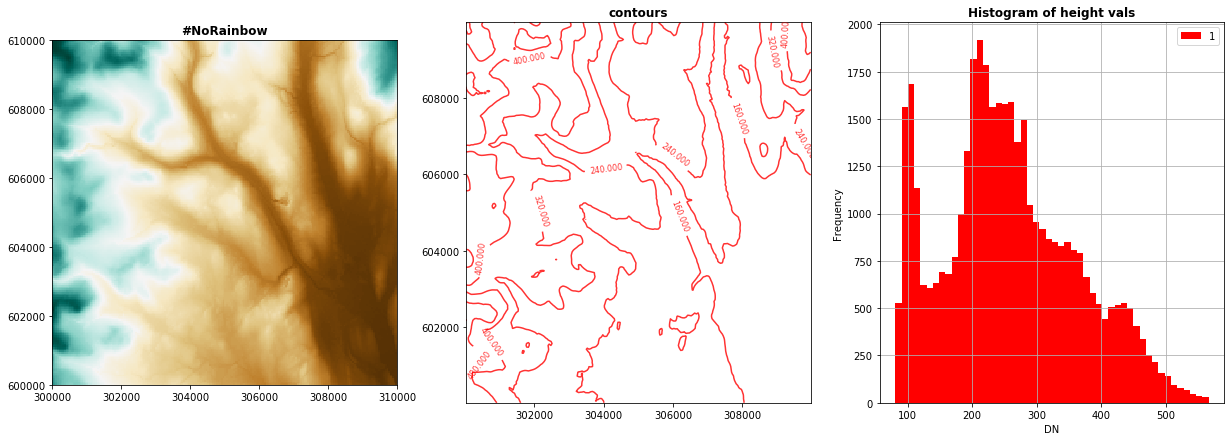

In [85]:
def make_nice_single_raster_plot(input_raster):
    fig, (ax1, ax2, ax3) = pyplot.subplots(1,3, figsize=(21,7))
    show(input_raster.read(), ax=ax1, transform=input_raster.transform, cmap='BrBG', title='#NoRainbow');
    show(input_raster.read(), ax=ax2, transform=input_raster.transform, contour=True, title='contours');
    show_hist(input_raster, bins=50, lw=0.0, stacked=False, histtype='stepfilled', title="Histogram of height vals")
    
make_nice_single_raster_plot(src)

# Part 2. Doing some processing, i.e. a merge

Next we're going to merge all rasters in the `raster_list` python list that we made earlier

<div class="alert alert-warning">
    <strong>Merging with rasterio</strong>
    <br> The merge module copies a list of actual raster data to an output file
    <br>Feel free to refer to rasterio merge <a href="https://rasterio.readthedocs.io/en/stable/api/rasterio.merge.html">documentation</a> 
</div>

The below cell creats the output raster in memory as the `dest` object  
However, `dest` just holds the data, and not the geographic meta

In [86]:
raster_obj_list = [rs.open(res) for res in raster_list]
dest, output_trans = merge.merge(raster_obj_list,bounds=None, res=None, nodata=None, precision=7)

Next, we need to burn the 'profile' information, i.e. the meta to the output file  
First we need to get a copy of one of the input rasters, using ... 

In [87]:
raster_obj_list[0].profile

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': None, 'width': 200, 'height': 200, 'count': 1, 'crs': CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",400000],PARAMETER["False_Northing",-100000],PARAMETER["Central_Meridian",-2],PARAMETER["Scale_Factor",0.999601272],PARAMETER["Latitude_Of_Origin",49],UNIT["Meter",1]]'), 'transform': Affine(50.0, 0.0, 300000.0,
       0.0, -50.0, 610000.0), 'tiled': False}

The final step of the merge, is to write the output file to disk using the `open` method with a `"w"` command

In [88]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rs.Env():

    # Write an array as a raster band to a new file. For
    # the new file's profile, we start with the profile of the source
    output_profile = raster_obj_list[0].profile

    # And then change the band count to 1, and set LZW compression.
    output_profile.update(
        {
            "driver": "GTiff",
            "height": dest.shape[1],
            "width": dest.shape[2],
            "transform": output_trans,
            "count": 1,
            "compress": 'lzw'
        }
    )

    with rs.open(os.path.join(pth_cwd,"merge.tif"), "w", **output_profile) as dest1:
        dest1.write(dest)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

<div class="alert alert-info">
    <strong>ACTIVITY</strong>
    <br> to check your output directory which should be ./tutorial/data/dem-working
    <br>Feel free to open the 'merge.tif' file in a desktop GIS
</div>

For completeness, we will open and read the merge.tif from disk

In [89]:
mrg = rs.open(os.path.join(pth_cwd,"merge.tif"))

Let's plot it

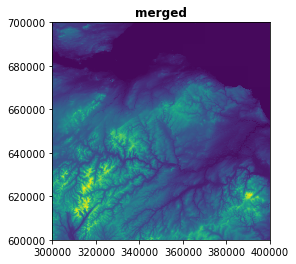

In [90]:
show(mrg.read(), transform=mrg.transform, title='merged');

To double check let's view the profile (meta data) 

In [91]:
mrg.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(50.0, 0.0, 300000.0,
       0.0, -50.0, 700000.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

The next cell reimport a custom utilities module (you can edit seperate modules but need to reload themn when to avoid a kernel restart)  
The module holds a copy of the make single raster 3-panel plot function that we used above

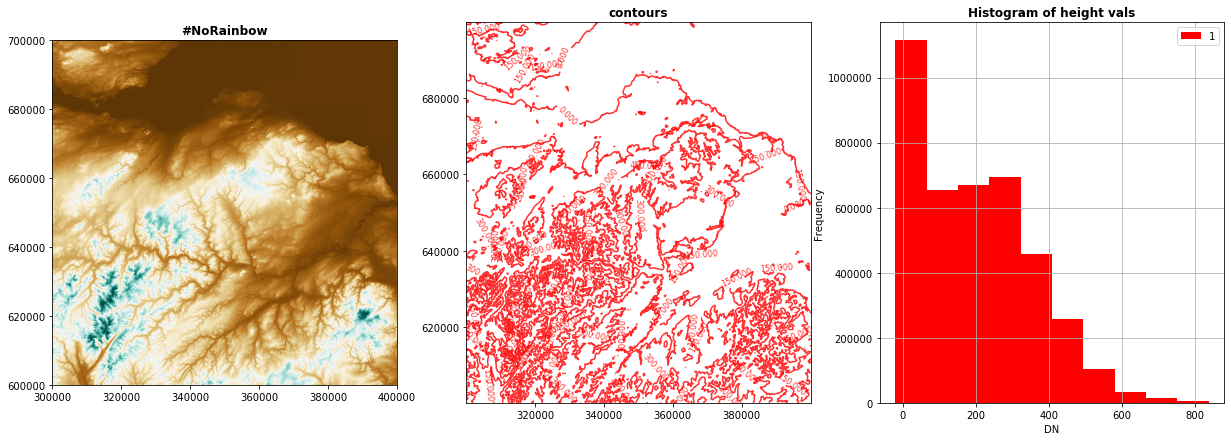

In [92]:
importlib.reload(utilities)
from utilities import make_nice_single_raster_plot

# plot with the latest merged raster
make_nice_single_raster_plot(mrg,10)

# Part 2. Sampling the Raster

### Sampling two locations
Grabbing coordinates from the lowerleft corner and upper right corner of the merged raster

In [93]:
locations = [(mrg.bounds.left + 1, mrg.bounds.bottom + 1),(mrg.bounds.right - 1, mrg.bounds.top - 1)];locations

[(300001.0, 600001.0), (399999.0, 699999.0)]

sample the raster with the list of tuple coordinates

In [94]:
res = [val.item(0) for val in mrg.sample(locations)];res

[473.70001220703125, 0.0]

### Sample the raster with a vector file to create an Elevation Profile
* For this, we will make use of the `geopandas` python package
* First we'll read in the vector linstring from the geojson file.
* Then, create equidistance points along that linestring.
* Then, sample the raster (meaning get the pixel value) for all points in the list
* Then graph the points

In [95]:
# run custom function to generate equi-distance points along the linestring
# these points will be used for sampling the raster DEM
path_to_linestring = os.path.join(os.path.join(root,'data'),'cycleway.geojson')
crs = 27700
interval_m = 1000
path_to_sampling_points = os.path.join(pth_cwd,'sampling-points.geojson')
utilities.make_equidistant_points_from_linstring(path_to_linestring,interval_m,crs,path_to_sampling_points)

In [96]:
gdf = geopandas.read_file(path_to_sampling_points)

In [97]:
# print the top five rows of the geo dataframe to review the structure of the data
gdf.head(5)

,id,geometry
0,1,POINT (310978.417847056 700000)
1,1,POINT (310761.5286886367 699051.9500723534)
2,1,POINT (310245.923753496 698251.8831087151)
3,1,POINT (309943.6052716977 697523.0419428193)
4,1,POINT (309254.3304549182 697024.0758923009)


## Note on Formats

The geometry for each record in the dataframe is in the `Well Known Text` format, i.e.
```python
POINT (310978.417847056 700000)
```
However, the rasterio `sample` method requires a list of all XY points used for sampling as a list of python tuples, i.e.
```python
[(x_point1, y_point1), (x_point2, y_point2), (x_point3, y_point3)]
```
Therefore some we need to do some data manipulation to fit to the rasterio arguments.

In [98]:
# burn the X and Y values to specific columns in the geodataframe
gdf['x'] = gdf['geometry'].apply(lambda p: p.x)
gdf['y'] = gdf['geometry'].apply(lambda p: p.y)
gdf.head(5)

,id,geometry,x,y
0,1,POINT (310978.417847056 700000),310978.417847,700000.000000
1,1,POINT (310761.5286886367 699051.9500723534),310761.528689,699051.950072
2,1,POINT (310245.923753496 698251.8831087151),310245.923753,698251.883109
3,1,POINT (309943.6052716977 697523.0419428193),309943.605272,697523.041943
4,1,POINT (309254.3304549182 697024.0758923009),309254.330455,697024.075892


In [99]:
# create a list of tuples of the X and Y values
geom_as_tuples = list(zip(gdf.x, gdf.y))
geom_as_tuples[:5]

[(310978.417847056, 700000.0),
 (310761.52868863667, 699051.9500723534),
 (310245.92375349597, 698251.8831087151),
 (309943.60527169774, 697523.0419428193),
 (309254.3304549182, 697024.0758923009)]

In [100]:
# sample the merged raster with each xy point in the list
list_elevations = []
for val in mrg.sample(geom_as_tuples):
    list_elevations.append(val.item(0))
list_elevations[:5]

[132.89999389648438,
 124.9000015258789,
 117.30000305175781,
 160.60000610351562,
 221.5]

In [101]:
# OR write the above loop as a python List Comprehension
list_elevations = [val.item(0) for val in mrg.sample(geom_as_tuples)]
list_elevations[:5]

[132.89999389648438,
 124.9000015258789,
 117.30000305175781,
 160.60000610351562,
 221.5]

In [102]:
# add the elevations as a column to the sampling geodataframe,
# Why? Because our geodataframe has a bunch of useful methods for plotting
gdf['elev'] = pandas.Series(list_elevations)
gdf.head(5)

,id,geometry,x,y,elev
0,1,POINT (310978.417847056 700000),310978.417847,700000.000000,132.899994
1,1,POINT (310761.5286886367 699051.9500723534),310761.528689,699051.950072,124.900002
2,1,POINT (310245.923753496 698251.8831087151),310245.923753,698251.883109,117.300003
3,1,POINT (309943.6052716977 697523.0419428193),309943.605272,697523.041943,160.600006
4,1,POINT (309254.3304549182 697024.0758923009),309254.330455,697024.075892,221.500000


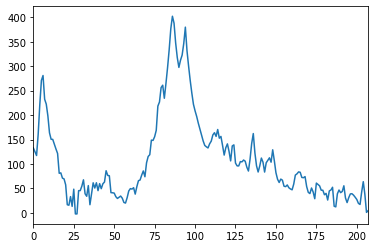

In [103]:
# plot the elevation "profile"
gdf['elev'].plot()

In [104]:
# create a slope GeoTIFF using the GDAL DEM Processing tool 
dest_dataset = os.path.join(pth_cwd, 'slope.tif')
src_dataset = os.path.join(pth_cwd, 'merge.tif')

try:
    gdal.DEMProcessing(dest_dataset,src_dataset,'slope',format='GTiff')
except Exception as e:
    print(e)

In [105]:
# open the slope dataset as a rasterio dataset
slope_data = rs.open(os.path.join(pth_cwd,"slope.tif"))

In [106]:
list_slope_vals = [val.item(0) for val in slope_data.sample(geom_as_tuples)]#;list_slope_vals

In [107]:
gdf['slope'] = pandas.Series(list_slope_vals)

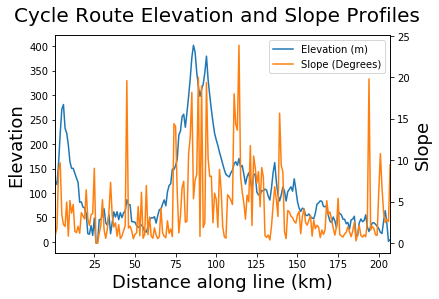

In [108]:
fig, ax = plt.subplots()
fig.suptitle('Cycle Route Elevation and Slope Profiles', fontsize=20)
ax1 = gdf['elev'].iloc[1:].plot(ax=ax)
ax2 = gdf['slope'].iloc[1:].plot(ax=ax, secondary_y=True)
ax1.set_xlabel('Distance along line (km)',fontsize=18)
ax1.set_ylabel('Elevation',fontsize=18)
ax2.set_ylabel('Slope',fontsize=18)
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], ['Elevation (m)','Slope (Degrees)'])